<font size="6"><b>LOAD NECESSARY LIBRARIES</b></font>

In [2]:
import cv2
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
import numpy as np
from skimage import segmentation
from skimage.filters import sobel
from PIL import Image
import click

<font size="6"><b>SENDER SIDE ALGORITHM</b></font>

<font size="5"><b>Module 1: ROI Mask Generation</b></font>

<font size="4"><b>1. Load Image</b></font>

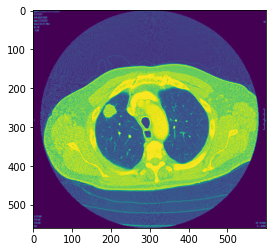

The shape of image: (560, 600)


In [3]:
src_img = cv2.imread('CT Scan.jpg', 0)
plt.imshow(src_img)
plt.show()
print("The shape of image:",src_img.shape)

From the shape of the numpy array representing the image, it is evident that there are 560 pixels along the vertical direction, 600 pixels along the horizontal direction. Note that it is a grayscale image

<font size="4"><b>2. Smoothen the Image</b></font>

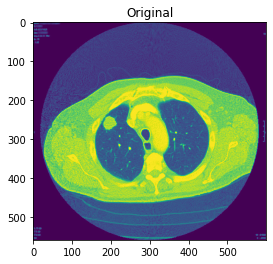

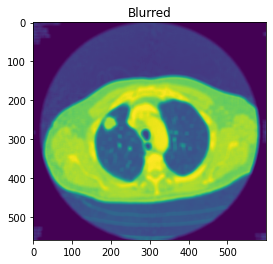

In [4]:
blur_img = cv2.blur(src_img,(10,10))
plt.imshow(src_img)
plt.title("Original")
plt.show()
plt.imshow(blur_img)
plt.title("Blurred")
plt.show()

<font size="4"><b>3. Construct Elevation map using Sobel filter</b></font>

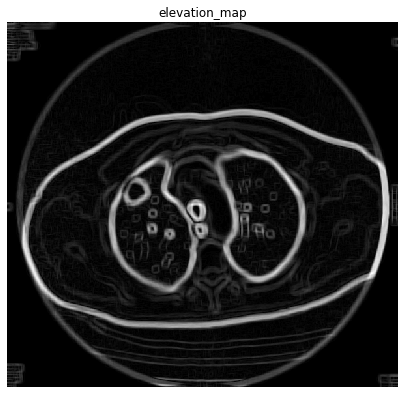

In [5]:
elevation_map = sobel(blur_img)

fig, ax = plt.subplots(figsize=(7,7))
ax.imshow(elevation_map, cmap="gray", interpolation='nearest')
ax.axis('off')
ax.set_title('elevation_map')
plt.show()

<font size="4"><b>4. Indentify the Intensity threshold value that defines the lung region</b></font>

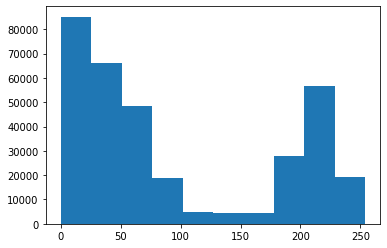

In [6]:
plt.hist(blur_img.flatten())
plt.show()

Text(0.5, 1.0, 'markers')

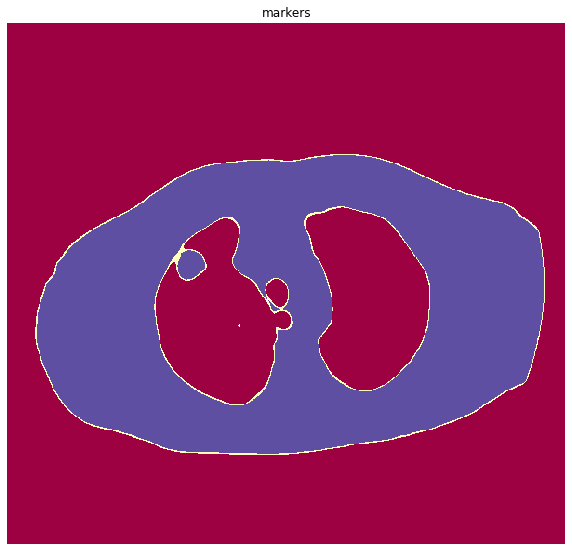

In [7]:
markers = np.zeros_like(blur_img)
markers[blur_img > 165] = 1
markers[blur_img > 185] = 2
markers[blur_img < 166] = 0

fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(markers, cmap='Spectral', interpolation='nearest')
ax.axis('off')
ax.set_title('markers')

Here, the Region of Interest(ROI) is the cancerous region in the lungs. The intensity range of the pixels constituting the cancerous region is [165, 185]

Text(0.5, 1.0, 'segmentation')

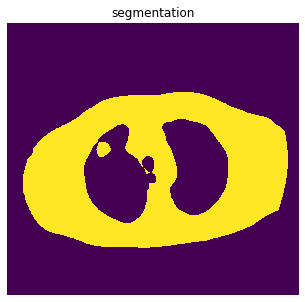

In [8]:
segment = segmentation.watershed(elevation_map, markers)

fig, ax = plt.subplots(figsize=(10,5))
ax.imshow(segment, interpolation='nearest')
ax.axis('off')
ax.set_title('segmentation')

This is the ROI mask. The yellow color represents the region containing the ROI and blue color represents the other surrouding region

Text(0.5, 1.0, 'segmentation after smoothing')

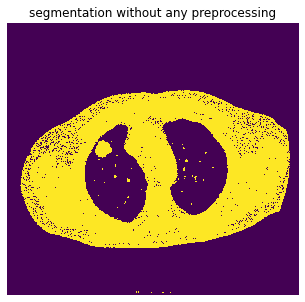

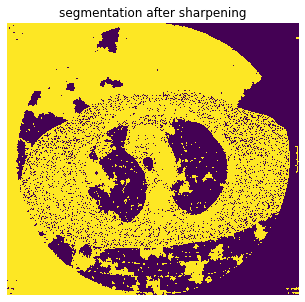

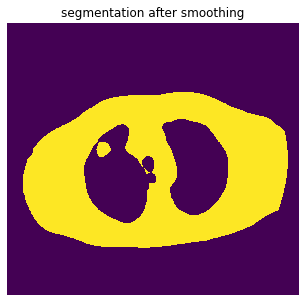

In [53]:
elevation_map_src = sobel(src_img)
markers_src = np.zeros_like(src_img)
markers_src[src_img > 165] = 1
markers_src[src_img > 185] = 2
markers_src[src_img < 166] = 0
segment_src = segmentation.watershed(elevation_map_src, markers_src)

sharpen_kernel = np.array([[0, -1, 0],
                   [-1, 5,-1],
                   [0, -1, 0]])
sharpen_img= cv2.filter2D(src=src_img, ddepth=-1, kernel=sharpen_kernel)

elevation_map_sharpen = sobel(sharpen_img)
markers_sharpen = np.zeros_like(sharpen_img)
markers_sharpen[sharpen_img > 165] = 1
markers_sharpen[sharpen_img > 185] = 2
markers_sharpen[sharpen_img < 166] = 0
segment_sharpen = segmentation.watershed(elevation_map_sharpen, markers_sharpen)

fig1, ax1 = plt.subplots(figsize=(10,5))
ax1.imshow(segment_src, interpolation='nearest')
ax1.axis('off')
ax1.set_title('segmentation without any preprocessing')

fig2, ax2 = plt.subplots(figsize=(10,5))
ax2.imshow(segment_sharpen, interpolation='nearest')
ax2.axis('off')
ax2.set_title('segmentation after sharpening')

fig3, ax3 = plt.subplots(figsize=(10,5))
ax3.imshow(segment, interpolation='nearest')
ax3.axis('off')
ax3.set_title('segmentation after smoothing')

From the above three images, it is obvious that segmentation after smoothing gives optmizized segmented mask

In [9]:
lis = []
for i in range(segment.shape[0]):
  for j in range(segment.shape[1]):
    if segment[i ,j] not in lis:
      lis.append(segment[i, j])

print(lis)

[1, 2]


2 is the intensity value of the pixels constituting region containing ROI and 1 is the intensity value of the pixels contituting the other region

<font size="5"><b>MODULE 2: FAKE IMAGE GENERATION</b></font>

<font size="4"><b>1. Load the input color image</b></font>

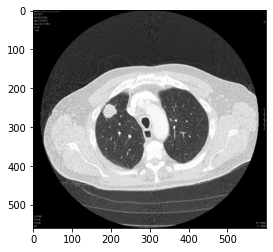

Shape of image: (560, 600, 3)


In [10]:
color_img = mpimg.imread("CT Scan.jpg")
plt.imshow(color_img)
plt.show()
print("Shape of image:", color_img.shape)

<font size="4"><b>2. Fake the Image</b></font>

In [11]:
class FakingUtil:
  def int_to_bin(self, rgb):
    r, g, b = rgb
    return (f'{r:08b}',
            f'{g:08b}',
            f'{b:08b}')
    
  def bin_to_int(self, rgb):
    r, g, b = rgb
    return (int(r, 2),
            int(g, 2),
            int(b, 2))
  def two_bit_swap_util(self, bin):
    return bin[6:8] + bin[4:6] + bin[2:4] + bin[0:2]
  def four_bit_swap_util(self, bin):
    return bin[4:8] + bin[0:4]
  def two_bit_swap(self, rgb):
    r, g, b = self.int_to_bin(rgb)
    return self.bin_to_int((self.two_bit_swap_util(r), self.two_bit_swap_util(g), self.two_bit_swap_util(b)))
  def four_bit_swap(self, rgb):
    r, g, b = self.int_to_bin(rgb)
    return self.bin_to_int((self.four_bit_swap_util(r), self.four_bit_swap_util(g), self.four_bit_swap_util(b)))

In [13]:
fakingUtil = FakingUtil()

fake_img = np.array(color_img)

for i in range(segment.shape[0]):
  for j in range(segment.shape[1]):
    if segment[i, j] == 1:
      fake_img[i, j] = np.array(fakingUtil.four_bit_swap(tuple(color_img[i, j])))
    elif segment[i, j] == 2:
      fake_img[i, j] = np.array(fakingUtil.two_bit_swap(tuple(color_img[i, j])))

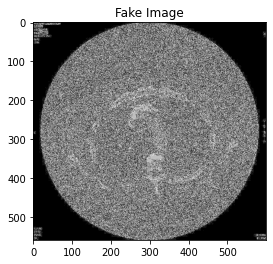

In [14]:
plt.imshow(fake_img)
plt.title("Fake Image")
plt.show()

<font size="4"><b>3. Save the fake image</b></font>

In [28]:
Image.fromarray(segment).convert('RGB').save('mask.jpg')
Image.fromarray(fake_img).save("fake.jpg")

<font size="5"><b>MODULE 3: LSB STEGANOGRAPHY</b></font>

In [17]:
class Steganography:

    @staticmethod
    def __int_to_bin(rgb):
        """Convert an integer tuple to a binary (string) tuple.
        :param rgb: An integer tuple (e.g. (220, 110, 96))
        :return: A string tuple (e.g. ("00101010", "11101011", "00010110"))
        """
        r, g, b = rgb
        return (f'{r:08b}',
                f'{g:08b}',
                f'{b:08b}')

    @staticmethod
    def __bin_to_int(rgb):
        """Convert a binary (string) tuple to an integer tuple.
        :param rgb: A string tuple (e.g. ("00101010", "11101011", "00010110"))
        :return: Return an int tuple (e.g. (220, 110, 96))
        """
        r, g, b = rgb
        return (int(r, 2),
                int(g, 2),
                int(b, 2))

    @staticmethod
    def __merge_rgb(rgb1, rgb2, mode):
        """Merge two RGB tuples.
        :param rgb1: A string tuple (e.g. ("00101010", "11101011", "00010110"))
        :param rgb2: Another string tuple
        (e.g. ("00101010", "11101011", "00010110"))
        :return: An integer tuple with the two RGB values merged.
        """
        r1, g1, b1 = rgb1
        r2, g2, b2 = rgb2
        if mode=="MSB":
          rgb = (r1[:4] + r2[:4],
                g1[:4] + g2[:4],
                b1[:4] + b2[:4])
        else:
          rgb = (r1[:4] + r2[4:],
                g1[:4] + g2[4:],
                b1[:4] + b2[4:])
        return rgb

    @staticmethod
    def merge(img1, img2, mode):
        """Merge two images. The second one will be merged into the first one.
        :param img1: First image
        :param img2: Second image
        :return: A new merged image.
        """

        # Check the images dimensions
        if img2.size[0] > img1.size[0] or img2.size[1] > img1.size[1]:
            raise ValueError('Image 2 should not be larger than Image 1!')

        # Get the pixel map of the two images
        pixel_map1 = img1.load()
        pixel_map2 = img2.load()

        # Create a new image that will be outputted
        new_image = Image.new(img1.mode, img1.size)
        pixels_new = new_image.load()

        for i in range(img1.size[0]):
            for j in range(img1.size[1]):
                rgb1 = Steganography.__int_to_bin(pixel_map1[i, j])

                # Use a black pixel as default
                rgb2 = Steganography.__int_to_bin((0, 0, 0))

                # Check if the pixel map position is valid for the second image
                if i < img2.size[0] and j < img2.size[1]:
                    rgb2 = Steganography.__int_to_bin(pixel_map2[i, j])

                # Merge the two pixels and convert it to a integer tuple
                rgb = Steganography.__merge_rgb(rgb1, rgb2, mode)

                pixels_new[i, j] = Steganography.__bin_to_int(rgb)

        return new_image

    @staticmethod
    def unmerge(img1, img2):
        """Unmerge an image.
        :param img1: The input 1 image.
        :param img2: The input 2 image.
        :return: The unmerged/extracted image.
        """

        # Load the pixel maps
        pixel_map1 = img1.load()
        pixel_map2 = img2.load()

        # Create the new image and load the pixel map
        iteration_shape = (min(img1.size[0], img2.size[0]), min(img1.size[1], img2.size[1]))
        new_image = Image.new(img1.mode, iteration_shape)
        pixels_new = new_image.load()

        # Tuple used to store the image original size
        original_size = iteration_shape

        for i in range(iteration_shape[0]):
            for j in range(iteration_shape[1]):
                # Get the RGB (as a string tuple) from the current pixel
                r1, g1, b1 = Steganography.__int_to_bin(pixel_map1[i, j])
                r2, g2, b2 = Steganography.__int_to_bin(pixel_map2[i, j])

                rgb = (r1[4:] + r2[4:],
                       g1[4:] + r2[4:],
                       b1[4:] + r2[4:])

                # Convert it to an integer tuple
                pixels_new[i, j] = Steganography.__bin_to_int(rgb)

                # If this is a 'valid' position, store it
                # as the last valid position
                if pixels_new[i, j] != (0, 0, 0):
                    original_size = (i + 1, j + 1)

        # Crop the image based on the 'valid' pixels
        new_image = new_image.crop((0, 0, original_size[0], original_size[1]))

        return new_image

In [18]:
"""
    img1 & img2 - Image that will hide another image
    src_img - Image that will be hidden
    output1 & output2 - Output image
"""

def merge(src_img, img1, img2, output1, output2):
    merged_image1 = Steganography.merge(Image.open(img1), Image.open(src_img), mode="MSB")
    merged_image2 = Steganography.merge(Image.open(img2), Image.open(src_img), mode="LSB")
    merged_image1.save(output1)
    merged_image2.save(output2)

merge("fake.jpg", "img1.jpg", "img2.jpg", "stego1.png", "stego2.png")

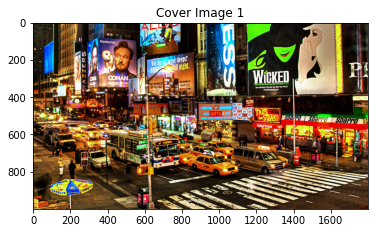

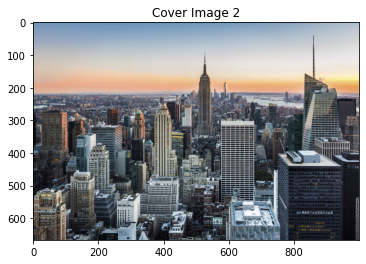

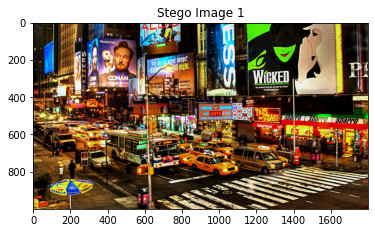

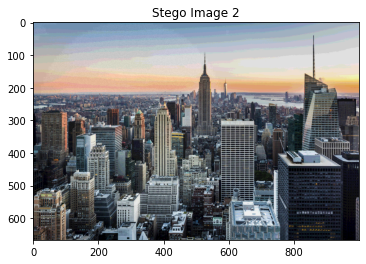

In [49]:
img1 = mpimg.imread("img1.jpg")
plt.imshow(img1)
plt.title("Cover Image 1")
plt.show()

img2 = mpimg.imread("img2.jpg")
plt.imshow(img2)
plt.title("Cover Image 2")
plt.show()

img3 = mpimg.imread("stego1.png")
plt.imshow(img3)
plt.title("Stego Image 1")
plt.show()

img4 = mpimg.imread("stego2.png")
plt.imshow(img4)
plt.title("Stego Image 2")
plt.show()

The two stego images (stego1.png, stego2.png) and encrypted mask image (mask.jpg) are transmitted to the receiver

<font size="6"><b>RECEIVER SIDE ALGORITHM</b></font>

<font size="5"><b>Module 1: LSB Steganography</b></font>

In [19]:
def unmerge(img1, img2, output):
    unmerged_image = Steganography.unmerge(Image.open(img1), Image.open(img2))
    unmerged_image.save(output)

unmerge("stego1.png", "stego2.png", "rec_fake.jpg")

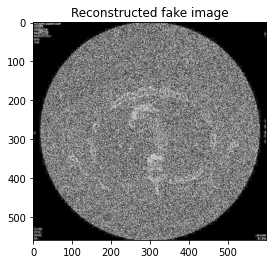

In [50]:
img5 = mpimg.imread("rec_fake.jpg")
plt.imshow(img5)
plt.title("Reconstructed fake image")
plt.show()

<font size="5"><b>MODULE 2: ORIGINAL IMAGE GENERATION</b></font>

<font size="4"><b>1. Load the reconstructed fake image and received mask image</b></font>

In [29]:
rec_fake = mpimg.imread("rec_fake.jpg")
rec_segment = Image.open("mask.jpg").convert("I")

<font size="4"><b>2. Contruct Original Image from fake</b></font>

In [31]:
fakingUtil = FakingUtil()

original = np.array(rec_fake)

for i in range(rec_fake.shape[0]):
  for j in range(rec_fake.shape[1]):
    if rec_segment[i, j] == 1:
      original[i, j] = np.array(fakingUtil.four_bit_swap(tuple(rec_fake[i, j])))
    elif rec_segment[i, j] == 2:
      original[i, j] = np.array(fakingUtil.two_bit_swap(tuple(rec_fake[i, j])))

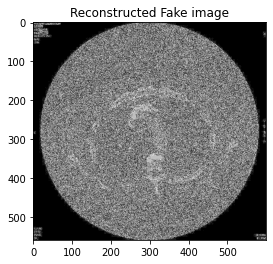

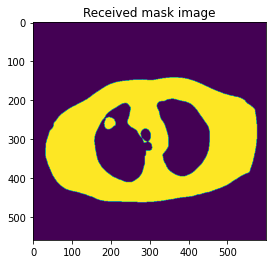

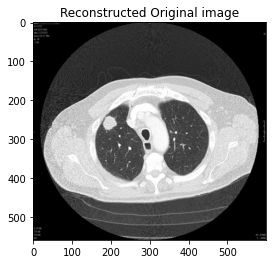

In [34]:
plt.imshow(rec_fake)
plt.title("Reconstructed Fake image")
plt.show()
plt.imshow(rec_segment)
plt.title("Received mask image")
plt.show()
plt.imshow(original)
plt.title("Reconstructed Original image")
plt.show()